In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from numba import jit, njit, vectorize, guvectorize, float64

plt.style.use(['science', 'grid', 'notebook'])

# Sinapsis de Neuoronas de Hodgkin-Huxley

## Parámetros de la neurona

In [2]:
# Definición de constantes del sistema
Vna = 50    # mV
Vk = -77
Vl = -54.4
Vsyn = -40
gna = 120   # mS/cm^2
gk = 36
gl = 0.3

tau_s = 3  # ms (constante de tiempo de la sinapsis)

C = 1   # microF/cm^2

# Definición de funciones de comportamiento de la membrana
@njit
def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-0.1 * (V + 40)))
@njit
def beta_m(V):
    return 4 * np.exp(-(V + 65) / 18)
@njit
def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)
@njit
def beta_h(V):
    return 1 / (1 + np.exp(-0.1 * (V + 35)))
@njit
def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))
@njit
def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)


# definicion de X_inf y tau_x
# @jit(forceobj=True)
@njit
def x_inf(V):
    res = np.empty((4, V.shape[0]))
    # print(V.shape[0])
    # print(V)
    for i in range(V.shape[0]):
        # print(V.shape[0]-i-1)
        res[:, i] = np.array([alpha_m(V[i]) / (alpha_m(V[i]) + beta_m(V[i])), alpha_h(V[i]) / (alpha_h(V[i]) + beta_h(V[i])), alpha_n(V[i]) / (alpha_n(V[i]) + beta_n(V[i])), 0.5*(1 + np.tanh(V[V.shape[0]-i-1]/5))])

    return res
    # return np.array([alpha_m(V) / (alpha_m(V) + beta_m(V)), alpha_h(V) / (alpha_h(V) + beta_h(V)), alpha_n(V) / (alpha_n(V) + beta_n(V)), 0.5*(1 + np.tanh(V[::-1]/5))])  # Se agrega la variable de estado de la sinapsis

# @jit(forceobj=True)
@njit
def tau_x(V):
    res = np.empty((4, V.shape[0]))
    for i in range(V.shape[0]):
        res[:, i] = np.array([1 / (alpha_m(V[i]) + beta_m(V[i])), 1 / (alpha_h(V[i]) + beta_h(V[i])), 1 / (alpha_n(V[i]) + beta_n(V[i])), tau_s])
    return res
    # return np.array([1 / (alpha_m(V) + beta_m(V)), 1 / (alpha_h(V) + beta_h(V)), 1 / (alpha_n(V) + beta_n(V)), tau_s*np.ones_like(V)])  # Se agrega la variable de estado de la sinapsis


In [62]:
# @jit(forceobj=True, looplift=True)
def euler_eq_resolver(seed, time_limits, delta_t, dydx, args):
    time_axis = np.arange(*time_limits, delta_t)    # defino eje temporal
    results = np.empty((*seed.shape, time_axis.size))            # defino matriz de potencial de membrana y variables de comportamiento
    # print(results.shape)
    results[..., 0] = seed

    for i in range(1, time_axis.size):
        results[..., i] = results[..., i - 1] + delta_t * dydx(results[..., i - 1], args)
    return results

In [3]:
N_neurons = 2

delta_t = 0.01
time_limits = (0, 2000)

V_seed = np.array([-60, -70])
seed = np.array([V_seed, *x_inf(0.8*V_seed)]) # la condicion inicial cerca del potencial de reposo
print(seed.shape)

@njit
def dVdt(V, m, h, n, s, args):
    gna, gk, gl, gsyn, Vna, Vk, Vl, Vsyn, I = args
    return (I - gna * m**3 * h * (V - Vna) - gk * n**4 * (V - Vk) - gl * (V - Vl) - gsyn * s * (V - Vsyn) ) / C
# @jit()
# @njit
# @jit(forceobj=True)
def dxdt(x, V):
    return (x_inf(V) - x) / tau_x(V)
# @jit(forceobj=True)
def derivate_system(x, args):
    return np.array([dVdt(x[0], *x[1:], args), *dxdt(x[1:], x[0])])

(5, 2)


In [5]:
gsyn_limits = (0, 2)
N_gsyn_points = 120
gsyn_values = np.linspace(*gsyn_limits, N_gsyn_points)


results = np.empty((N_gsyn_points, *seed.shape, int((time_limits[1] - time_limits[0]) / delta_t)))

for i, gsyn in enumerate(tqdm.tqdm(range(N_gsyn_points))):
    results[i] = solve_ivp(derivate_system, time_limits, seed, args=(gna, gk, gl, gsyn_values[i], Vna, Vk, Vl, Vsyn, 10), vectorized=True)

    # results[i] = euler_eq_resolver(seed, time_limits, delta_t, derivate_system, (gna, gk, gl, gsyn, Vna, Vk, Vl, Vsyn,  10))

  0%|          | 0/120 [00:00<?, ?it/s]


ValueError: `y0` must be 1-dimensional.

Busco los picos

In [53]:
desfasajes = np.empty(N_gsyn_points)

time_axis = np.arange(*time_limits, delta_t)
plot = False
n_peaks = 4

n_strip = 0

for i in range(N_gsyn_points):
    peaks = np.empty((N_neurons,), dtype=object)
    for j in range(N_neurons):
        p, _ = find_peaks(results[i, 0, j], distance=20, height=-20)
        if p.size > 1:
            peaks[j] = p
    # medicion de desfasaje
    if peaks[0] is not None and peaks[1] is not None:
        # spike_time = (time_axis[peaks[0][-1]] - time_axis[peaks[0][-2]])
        spike_time = (peaks[0][-1] - peaks[0][-2])
        # desfasajes[i] = np.mean(time_axis[peaks[1][-n_peaks:]] - time_axis[peaks[0][-n_peaks:]])   # mido cuando llegue al estacionario
        # desfasajes[i] = np.mean(peaks[0][-n_peaks:] - peaks[1][-n_peaks:]) * delta_t
        desf_prev = np.abs(peaks[0][-1] - peaks[1][-1])
        # Chequeo que el ultimo pico se formo bien
        if desf_prev > spike_time:
            print('Desfasaje mayor al tiempo de spike')
            desf_prev_1 = np.abs(peaks[0][-1] - peaks[1][-2])
            desf_prev_2 = np.abs(peaks[0][-2] - peaks[1][-1])
            desf_prev = np.min([desf_prev_1, desf_prev_2])
        desfasajes[i] = 2 * np.pi * desf_prev / spike_time
        
        print(f'Gsyn: {gsyn_values[i]:.2f}')
        print(f'Spike time: {spike_time:.2f} ms')
        print(f'Desfasaje: {desfasajes[i]:.2f} rad')
    else:
        desfasajes[i] = np.nan


    if plot:

        plt.figure(figsize=(12, 8))
        plt.plot(time_axis[-n_strip:], results[i, 0, 0][-n_strip:], label='Neurona 1', color = 'red')
        plt.plot(time_axis[-n_strip:], results[i, 0, 1][-n_strip:], label='Neurona 2', color='blue')
        plt.title(f'Gsyn = {gsyn_values[i]:.2f}')
        if peaks[0] is not None:
            plt.plot(time_axis[peaks[0]], results[i, 0, 0][peaks[0]], 'X', color = 'black')
        if peaks[1] is not None:
            plt.plot(time_axis[peaks[1]], results[i, 0, 1][peaks[1]], 'X', color='grey')
        plt.xlim([1750, 2000])
        # plt.xlim([0, 100])
        plt.legend()
        plt.show()

    # plt.plot(time_axis[peaks[0]], results[i, 0, 1][peaks[0]], 'X', label='Neurona 2', color = 'black')
    # plt.plot(time_axis[peaks[1]], results[i, 0, 1][peaks[1]], 'X', label='Neurona 2', color='black')

        # print(results[i, 0, j].shape)

del time_axis

Gsyn: 0.00
Spike time: 1464.00 ms
Desfasaje: 5.18 rad
Gsyn: 0.02
Spike time: 1507.00 ms
Desfasaje: 0.00 rad
Gsyn: 0.03
Spike time: 1557.00 ms
Desfasaje: 0.00 rad
Gsyn: 0.05
Spike time: 2014.00 ms
Desfasaje: 0.77 rad
Gsyn: 0.07
Spike time: 1973.00 ms
Desfasaje: 0.66 rad
Gsyn: 0.08
Spike time: 1600.00 ms
Desfasaje: 0.74 rad
Gsyn: 0.10
Spike time: 1647.00 ms
Desfasaje: 0.67 rad
Gsyn: 0.12
Spike time: 2039.00 ms
Desfasaje: 0.52 rad
Gsyn: 0.13
Spike time: 2100.00 ms
Desfasaje: 0.48 rad
Gsyn: 0.15
Spike time: 2885.00 ms
Desfasaje: 0.34 rad
Gsyn: 0.17
Spike time: 3235.00 ms
Desfasaje: 0.30 rad
Gsyn: 0.18
Spike time: 4035.00 ms
Desfasaje: 0.23 rad
Gsyn: 0.20
Spike time: 5149.00 ms
Desfasaje: 0.18 rad
Gsyn: 0.22
Spike time: 6546.00 ms
Desfasaje: 0.14 rad
Gsyn: 0.24
Spike time: 7353.00 ms
Desfasaje: 0.12 rad
Gsyn: 0.25
Spike time: 8729.00 ms
Desfasaje: 0.10 rad
Gsyn: 0.27
Spike time: 8728.00 ms
Desfasaje: 0.10 rad
Gsyn: 0.29
Spike time: 10636.00 ms
Desfasaje: 0.08 rad
Gsyn: 0.30
Spike time: 1178

(0.0, 6.283185307179586)

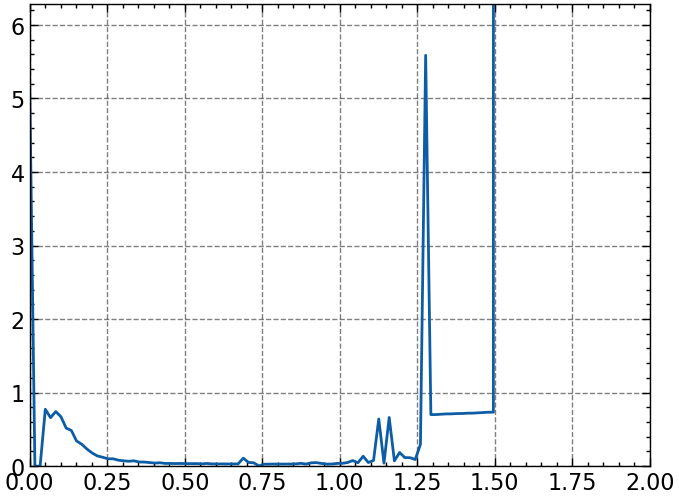

In [59]:
plt.plot(gsyn_values, desfasajes)
plt.xlim([0, 2])
plt.ylim([0, 2*np.pi])

(10, 5, 2, 150000)
(5, 2, 150000)


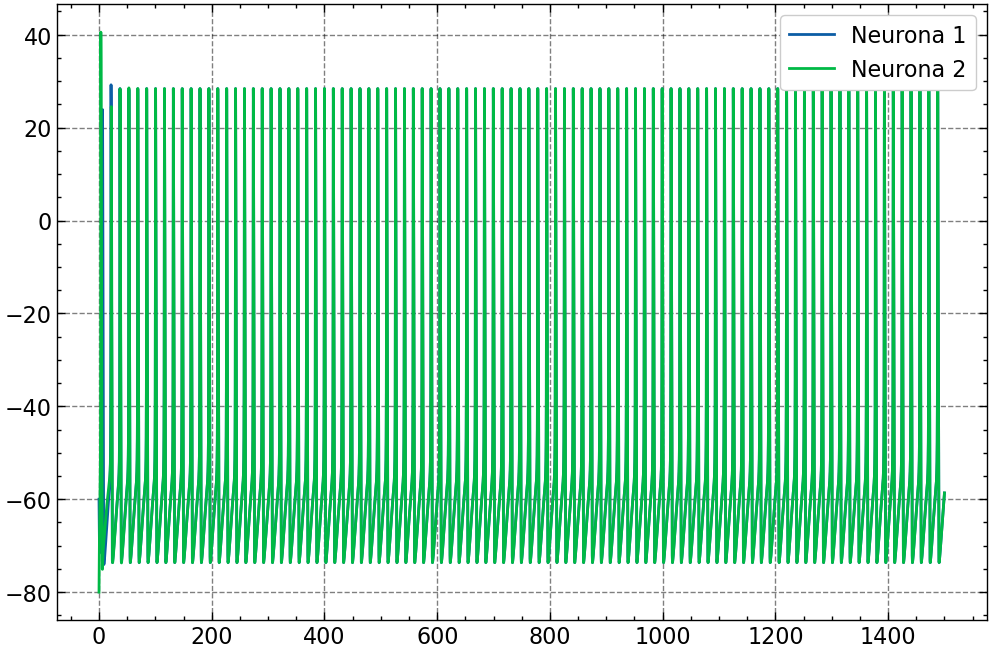

In [24]:
time_axis = np.arange(*time_limits, delta_t)
print(results.shape)
print(results[0].shape)

plt.figure(figsize=(12, 8))
plt.plot(time_axis, results[1, 0, 0, :], label='Neurona 1')
plt.plot(time_axis, results[1, 0, 1, :], label='Neurona 2')
plt.legend()


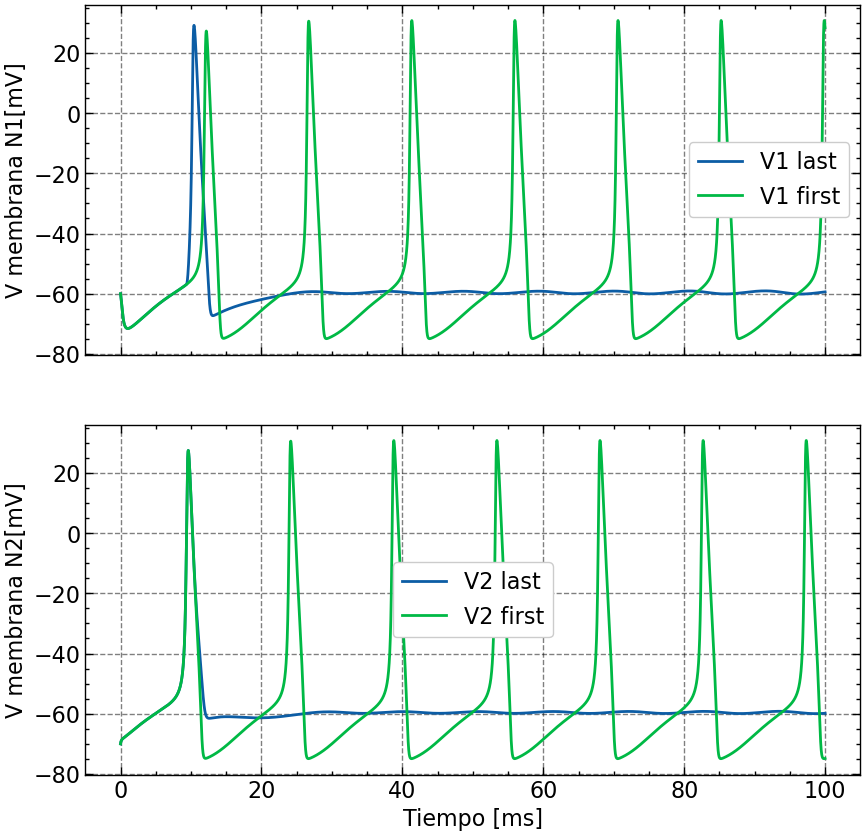

In [121]:
# fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# ax[0].plot(np.arange(*time_limits, delta_t), results[-1, 0, 0,  :], label='V1 last')
# ax[1].plot(np.arange(*time_limits, delta_t), results[-1, 0, 1,  :], label='V2 last')

# ax[0].plot(np.arange(*time_limits, delta_t), results[0, 0, 0,  :], label='V1 first')
# ax[1].plot(np.arange(*time_limits, delta_t), results[0, 0, 1,  :], label='V2 first')
# ax[1].set_xlabel('Tiempo [ms]')
# ax[0].set_ylabel('V membrana N1[mV]')
# ax[1].set_ylabel('V membrana N2[mV]')

# ax[0].legend()
# ax[1].legend()


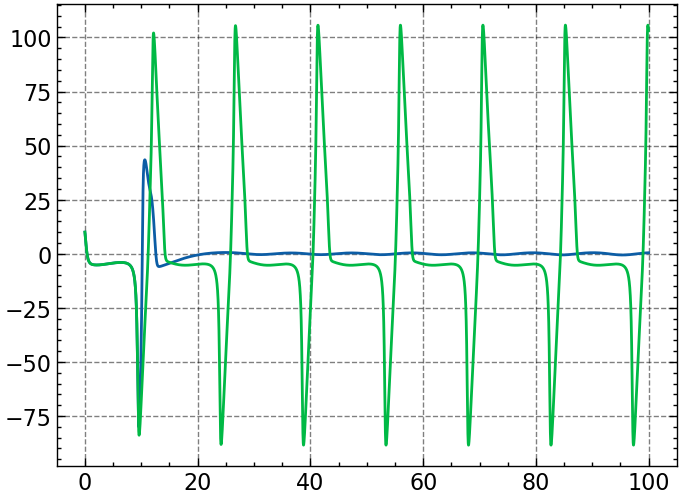

In [123]:
# plot de la diferencia

plt.plot(np.arange(*time_limits, delta_t), results[-1, 0, 0,  :] - results[-1, 0, 1,  :], label='V1 - V2 last')
plt.plot(np.arange(*time_limits, delta_t), results[0, 0, 0,  :] - results[0, 0, 1,  :], label='V1 - V2 first')

In [124]:
print(results.shape)
np.any((results[:, :, 0, :] - results[:, :, 1, :]) != 0)
# np.any((results[:, :, 0, :] - results[:, :, 1, :]) 

(100, 5, 2, 10000)


np.True_